In [1]:
%matplotlib inline  

/home/fabiozabe/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


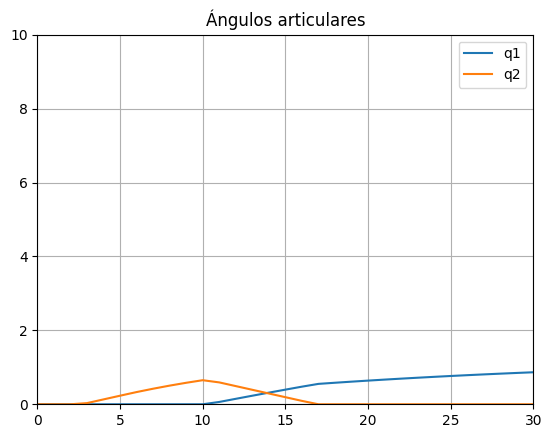

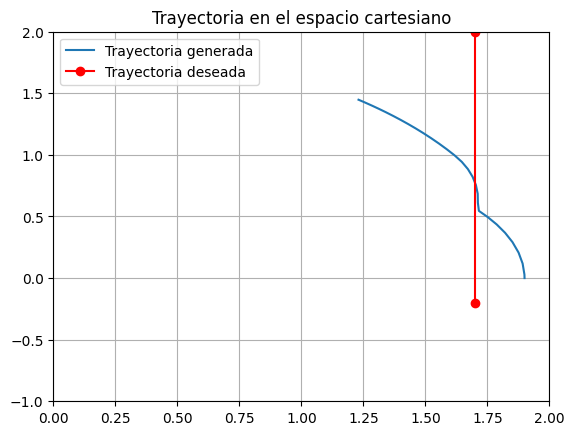

In [16]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt

# Parámetros
D = 2 # Grados de libertad
N = 30  # Número de puntos
l1, l2 = 1.0, 0.9
A = np.array([1.7, -0.2])
E = np.array([1.7, 2.0])

# Variables de decisión: q = [q1_0, q2_0, ..., q1_N, q2_N]
q = ca.MX.sym("q", D*(N+1))  # 2 ángulos por instante de tiempo

# Función de cinemática directa
def fkin(q):
    x = l1 * ca.cos(q[0]) + l2 * ca.cos(q[0] + q[1])
    y = l1 * ca.sin(q[0]) + l2 * ca.sin(q[0] + q[1])
    return ca.vertcat(x, y)

# Función objetivo (error total con la trayectoria deseada)
cost = 0
for k in range(N+1):
    qk = q[D*k:D*(k+1)]
    xk = fkin(qk)
    xd = A + (E - A) * k / N  # punto deseado (interpolación lineal)
    cost += ca.sumsqr(xk - xd)  # suma de distancias

# Definir restricciones 
lbx = [0] * (D*(N+1))         # límite inferior
ubx = [np.pi] * (D*(N+1))     # límite superior


# restricciones de velocidad
dt = 0.1
dq_min = np.array([-1]*D)
dq_max = np.array([1]*D)

g = []
g_lb = []
g_ub = []

for k in range(N):
    qk   = q[D*k   : D*(k+1)]
    qk1  = q[D*(k+1): D*(k+2)]
    dqk  = (qk1 - qk) / dt  # vector de velocidades articulares
    for i in range(D):
        g.append(dqk[i])             # velocidad i en el instante k
        g_lb.append(dq_min[i])       # límite inferior de velocidad
        g_ub.append(dq_max[i])       # límite superior de velocidad

g = ca.vertcat(*g)


# Configurar el solver
nlp = {"x": q, "f": cost, "g":g}
opts = {"ipopt.print_level": 0, "print_time": 0}
solver = ca.nlpsol("solver", "ipopt", nlp, opts)

# Resolver
sol = solver(lbx=lbx, ubx=ubx,lbg=g_lb, ubg=g_ub)
q_opt = sol["x"].full().reshape(N+1,2)  # 2 filas: q1, q2

# Trayectoria cartesiana resultante
X = []
for k in range(N+1):
    q_result = q_opt[k, :]
    xk = fkin(q_result)
    X.append(ca.evalf(xk).full().flatten())
X = np.array(X).T  # 2 x (N+1)

# Graficar ángulos
plt.figure()
plt.plot(q_opt[:, 0], label='q1')
plt.plot(q_opt[:, 1], label='q2')
plt.axis([0, 30, 0, 10])
plt.legend()
plt.title("Ángulos articulares")
plt.grid()

# Graficar trayectoria cartesiana
plt.figure()
plt.plot(X[0], X[1], label="Trayectoria generada")
plt.plot([A[0], E[0]], [A[1], E[1]], 'or-', label="Trayectoria deseada")
plt.axis([0, 2, -1, 2])
plt.legend()
plt.title("Trayectoria en el espacio cartesiano")
plt.grid()
plt.show()
